<p style="font-size:300%; text-align:center"> king county housing price modeling</p>
<p style="font-size:150%; text-align:center"> Normalizing</p>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
plt.style.use('ggplot')

##  Read the clean KC housing data

In [2]:
kc = pd.read_csv('data/kc_house_data_clean.csv')
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 21 columns):
id               21398 non-null int64
date             21398 non-null object
price            21398 non-null int64
bedrooms         21398 non-null int64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
waterfront       21398 non-null float64
view             21398 non-null float64
condition        21398 non-null int64
grade            21398 non-null int64
sqft_above       21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null int64
zipcode          21398 non-null int64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
tot_bathrooms    21398 non-null float64
dtypes: float64(13), int64(7), object(1)
memory usage: 3.4+ MB


In [3]:
# looks like the data types have changed. 
kc['id'] = kc['id'].astype('int64') 
kc['date']= pd.to_datetime(kc['date']) 
kc['price'] = kc['price'].astype('int64') 
kc['bedrooms'] = kc['bedrooms'].astype('int64') 
kc['bathrooms'] = kc['bathrooms'].astype('float64') 
kc['sqft_living'] = kc['sqft_living'].astype('float64') 
kc['sqft_lot'] = kc['sqft_lot'].astype('float64') 
kc['floors'] = kc['floors'].astype('float64') 
kc['waterfront'] = kc['waterfront'].astype('float64') 
kc['view'] = kc['view'].astype('float64') 
kc['condition'] = kc['condition'].astype('int64') 
kc['grade'] = kc['grade'].astype('int64') 
kc['sqft_above'] = kc['sqft_above'].astype('float64') 
kc['yr_built'] = kc['yr_built'].astype('int64') 
kc['zipcode'] = kc['zipcode'].astype('int64') 
kc['lat'] = kc['lat'].astype('float64') 
kc['long'] = kc['long'].astype('float64') 
kc['sqft_living15'] = kc['sqft_living15'].astype('float64') 
kc['sqft_lot15'] = kc['sqft_lot15'].astype('float64')
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 21 columns):
id               21398 non-null int64
date             21398 non-null datetime64[ns]
price            21398 non-null int64
bedrooms         21398 non-null int64
bathrooms        21398 non-null float64
sqft_living      21398 non-null float64
sqft_lot         21398 non-null float64
floors           21398 non-null float64
waterfront       21398 non-null float64
view             21398 non-null float64
condition        21398 non-null int64
grade            21398 non-null int64
sqft_above       21398 non-null float64
sqft_basement    21398 non-null float64
yr_built         21398 non-null int64
zipcode          21398 non-null int64
lat              21398 non-null float64
long             21398 non-null float64
sqft_living15    21398 non-null float64
sqft_lot15       21398 non-null float64
tot_bathrooms    21398 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(7)
memory us

In [4]:
'''
price in $ span a large range of numbers while all the features has quite short range. It could be better to take the log
scale of the price before fitting. 
'''
kc['price'] = np.log(kc['price'])


## Check for Multicollinearity
There are too many features and it's good to remove the unnecessary features just to reduce the clutter. Let's drop 
id, price, zipcode, 
### HeatMap

In [5]:
# Temporarily drop unnecessary columns so the heatmap is uncluttered
kc_corr = kc.drop(columns=['price', 'id', 'zipcode', 'date']) # kc_corr is just for heatmap

(17.0, 0.0)

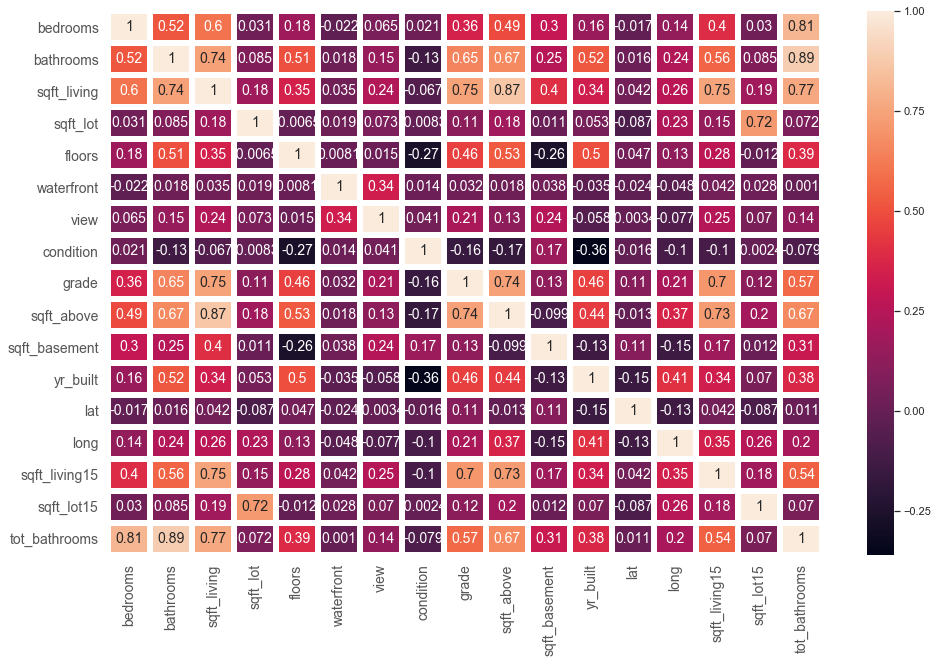

In [50]:
corr_df = kc_corr.corr()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

sns.set(rc={'figure.figsize':(16.0, 10.0)})
ax = sns.heatmap(corr_df, linewidth = 5, annot=True, annot_kws={"size":14})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
# I have no idea it looks wierd the 1st time running. I have to re-run it to make it look bigger 

From the correlation map above we can say that 
* not symmetric. negative correlations are closer to zero and not significant
* positive correlations above 0.75 looks quite significant. They are 
     * bathrooms   vs sqft_living   0.76
     * sqft_living vs grade         0.76
     * sqft_living vs sqft_above    0.88
     * sqft_living vs sqft_living15 0.76
     * grade       vs sqft_above    0.76
* sqft_above and sqft_living are highly correlated 
Let's explore those features in a scatter plot 

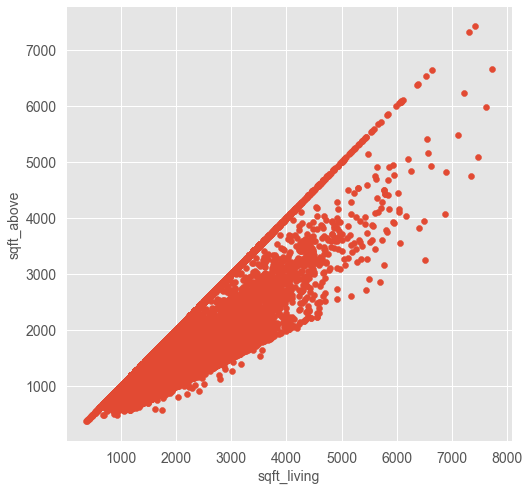

In [7]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.xlabel("sqft_living", fontsize=14)
plt.ylabel("sqft_above", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(kc.sqft_living, kc.sqft_above)

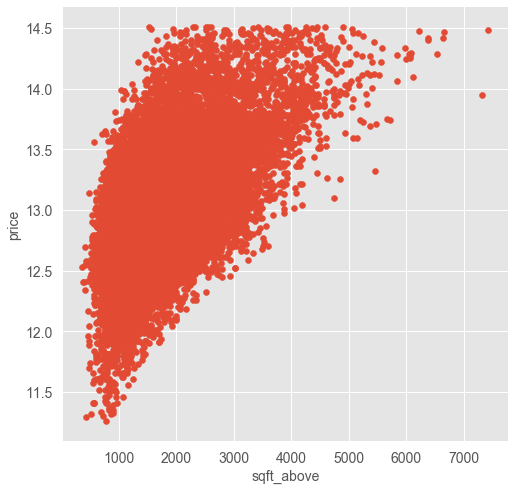

In [8]:
plt.figure(figsize=(8,8))
plt.xlabel("sqft_above", fontsize=14)
plt.ylabel("price", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.scatter(kc.sqft_above, kc.price)

The two features are highly correlated and sqft_above can be dropped. living sqft inlcudes basement space and it more representative of the total area of the house.

In [9]:
kc = kc.drop(['sqft_above'], axis=1) #dropping the sqft_above column from the dataset

### Scatter Matrix
To understand the correlations and data better the scatter matrix is important. Apart from being able to identify possible linear correlations quickly, it allows to identify the categorical features. 

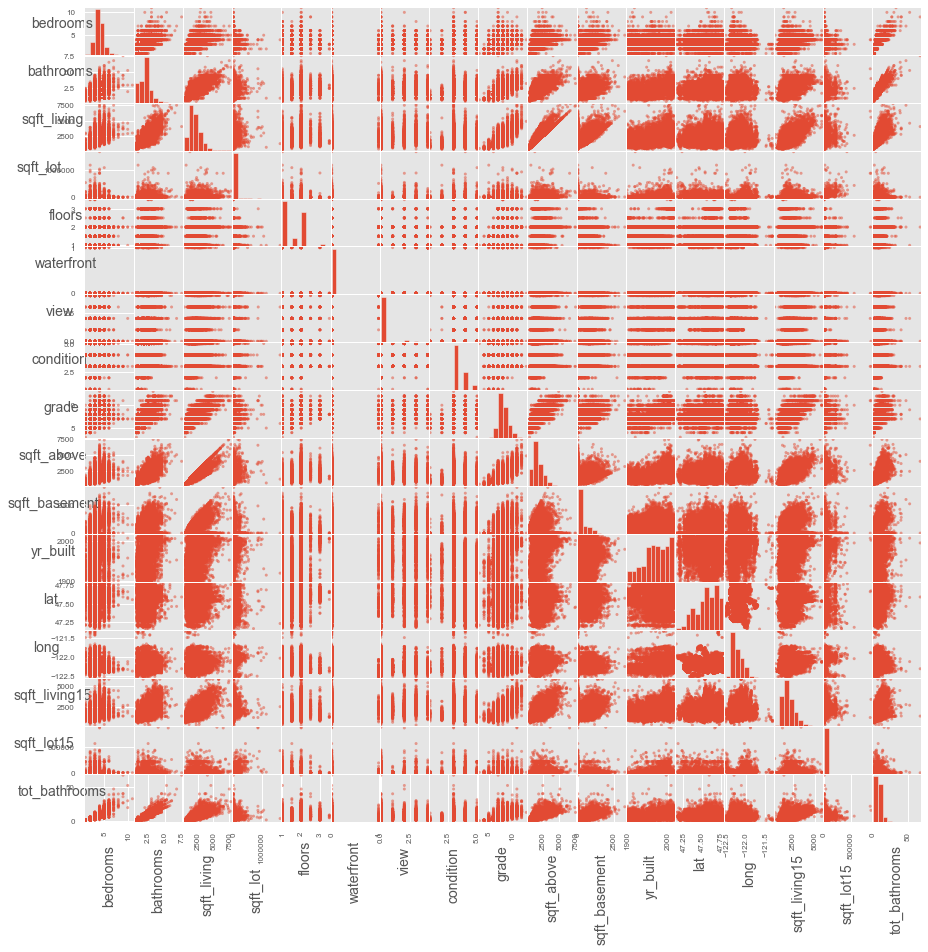

In [10]:
scatter_matrix = pd.plotting.scatter_matrix(kc_corr, figsize  = [15, 15]);

for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize = 14, rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 14, rotation = 0)
plt.show()

What can we see from the scatter matrix above? It's easier to identify categorical variables. 
what are the categorical variables ? 
* floors
* waterfront
* view
* condition
* possibly 'grade' 

## Initial model
To better gauage the progress let's model without any change to the features


In [11]:
# import statistical libraries for modelling. 
import statsmodels.api as sm
from statsmodels.formula.api import ols

### simple linear regression
It maybe worthwhile to investigate correlation between each individual feature with the outcome, which is the price 

In [12]:
kc.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'tot_bathrooms'],
      dtype='object')

#### using OLS of  statsmodels.api

In [13]:
tmp_y = kc[["price"]]
tmp_X = kc.drop(["price", "id", "date"], axis=1)
tmp_X.shape
y = tmp_y.iloc[:,0].values
X = tmp_X.iloc[:,0:].values

In [14]:
for i in range(np.size(X,1)):
    print("formula = price ~ "+tmp_X.columns[i])
    regressor_OLS = sm.OLS(y, X[:, [i]]).fit()
    print(regressor_OLS.summary())
    print("################################################################################\n\n")

formula = price ~ bedrooms
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.938
Model:                            OLS   Adj. R-squared (uncentered):              0.938
Method:                 Least Squares   F-statistic:                          3.265e+05
Date:                Wed, 06 May 2020   Prob (F-statistic):                        0.00
Time:                        11:59:31   Log-Likelihood:                         -55480.
No. Observations:               21398   AIC:                                  1.110e+05
Df Residuals:                   21397   BIC:                                  1.110e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

#### using OLS of  statsmodels.formula.api

In [15]:
predictors = tmp_X.columns

for idx, val in enumerate(predictors):
    print("formula = price ~ "+val)
    f = 'price ~ ' + val
    model = ols(formula=f, data=kc).fit()
    print(model.summary())
    print("################################################################################\n\n")


formula = price ~ bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2758.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:31   Log-Likelihood:                -14255.
No. Observations:               21398   AIC:                         2.851e+04
Df Residuals:                   21396   BIC:                         2.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3988    

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
################################################################################


formula = price ~ yr_built
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     153.5
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.96e-35
Time:                        11:59:32   Log-Likelihood:                -15476.
No. Observations:               21398   AIC:                         3.096e+04
Df Residuals:                   21396   BIC:                         3.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
        

The R2 values between statsmodels.api and statsmodels.formula.api are totally different. statsmodels.api has very high value and statsmodels.formula.api has a very low value. Visual inspection of the data shows most of the features are not linearly related. Thus, it is important to differentiate between these two options in the same statsmodels library. 

### multiple linear regression

In [16]:
kc.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'tot_bathrooms'],
      dtype='object')

In [17]:
tmp_y = kc[["price"]]
tmp_X = kc.drop(["price", "id", "date"], axis=1)
tmp_X.shape

(21398, 17)

In [18]:
#X_opt = X[:, [0, 1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15]]
X_opt = X[:, [i for i in range(np.size(X,1))]]
regressor_OLS = sm.OLS(y, X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.427e+06
Date:                Wed, 06 May 2020   Prob (F-statistic):                        0.00
Time:                        11:59:32   Log-Likelihood:                         -681.41
No. Observations:               21398   AIC:                                      1397.
Df Residuals:                   21381   BIC:                                      1532.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0167      0.005      3.327      0.001       0.007       0.026
x2             0.1242      0.009     14.406      0.000       0.107       0.141
x3             0.0001   4.83e-06     28.471      0.000       0.000       0.000
x4           4.75e-07   5.96e-08      7.971      0.000    3.58e-07    5.92e-07
x5             0.0798      0.004     17.918      0.000       0.071       0.089
x6             0.3622      0.026     13.775      0.000       0.311       0.414
x7             0.0623      0.003     23.225      0.000       0.057       0.068
x8             0.0569      0.003     19.798      0.000       0.051       0.063
x9             0.1560      0.003     57.419      0.000       0.151       0.161
x10         1.933e-05   5.46e-06      3.538      0.000    8.62e-06       3e-05
x11           -0.0037    8.2e-05    -45.251      0.000      -0.004      -0.004
x12           -0.0007   2.22e-05    -29.584      0.000      -0.001      -0.001
x13            1.3910      0.013    104.156      0.000       1.365       1.417
x14           -0.1349      0.016     -8.271      0.000      -0.167      -0.103
x15         9.205e-05   4.32e-06     21.322      0.000    8.36e-05       0.000
x16        -2.333e-07   9.11e-08     -2.560      0.010   -4.12e-07   -5.46e-08
x17           -0.0146      0.002     -6.958      0.000      -0.019      -0.010
==============================================================================
Omnibus:                      297.725   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.379
Skew:                          -0.013   Prob(JB):                    2.07e-122
Kurtosis:                       3.792   Cond. No.                     1.55e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R2 values of statsmodels.api above is unrealistic. Thus, I'm assuming there is a bug in the algorith and will use statsmodels.formula.api OLS algorith insted from now on. 

In [19]:
tmp_kc = kc.drop(["id", "date"], axis=1) # obviously date datatype won't work with OLS  
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3792.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:32   Log-Likelihood:                -680.38
No. Observations:               21398   AIC:                             1397.
Df Residuals:                   21380   BIC:                             1540.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.2451      3.655     -1.435

The R2 values of 0.750 from statsmodels.formula.api OLS algorith is much more realistic and reasonable without handling the categorical data and without normalization of any king.


## Categorical and Numerical features
The categorical and numerical data must be handled appropriately. Some features such as date sold may be binned into seasons, which makes it easier to handle and much less complicated when fitting. Then all other numerical data may be normalized so that much more reasonable fitting parameters may be obtained when fitting. 

### Latitude and Longitude is inherently  correlated and cannot be treated separately

The zipcode, latitude and longitude all shows the location. While zipcode represents a region and inherently a categorical feature. The latitude+longitude is a much more precise measure of location of a given house. While in a single zipcode there may be a wide range of prices in the close neighborhood prices tend to be similar. Although latitude and longitude separately do not provide much useful information, it can be used to calculate distances relative to a fix point in the region. It should be noted that latitude and longitude are essentially angles and need quite complex conversions to transform them to distances. However, for a small enough region and a county they can be approximated to coordinates in a flat plane without loss of generality. The focal point that makes most sense is the official coordinates of Seattle, which is (47.6062, -122.3321). The ‘-’ on longitude represents ‘west’. For a house with coordinates (x1, y1) by applying ‘haversine’ formula for the distance ‘r’ can be calculated as follows 

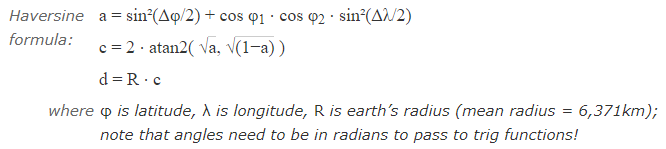

[haversine formula source](https://www.movable-type.co.uk/scripts/latlong.html)


In [20]:
def Cal_dist(lat2, lon2):
    #lat2=47.5112; lon2=-122.257
    lat1=47.6062; lon1=122.3321 # Seattel
    R = 6371*10^3; # in meters
    φ1 = lat1 * np.pi/180; # φ, λ in radians
    φ2 = lat2 * np.pi/180;
    Δφ = (lat2-lat1) * np.pi/180;
    Δλ = (lon2-lon1) * np.pi/180;

    a = np.sin(Δφ/2) * np.sin(Δφ/2) + np.cos(φ1) * np.cos(φ2) * np.sin(Δλ/2) * np.sin(Δλ/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a));

    d = (R * c )/1000; # in kilo metres km
    return d
    
print(Cal_dist(47.5112, -122.257))

77.348990250629


In [21]:
kc['r'] = kc.apply(lambda row: Cal_dist(row.lat, row.long) , axis=1)
display(kc[['lat', 'long', 'r']].head())
print(kc.columns)

,lat,long,r
0,47.5112,-122.257,77.348990
1,47.7210,-122.319,77.141575
2,47.7379,-122.233,77.169163
3,47.5208,-122.393,77.274453
4,47.6168,-122.045,77.362968


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'tot_bathrooms', 'r'],
      dtype='object')


In [22]:
# now let's redo the OLS by replacing lattitude and longitude, lat and long with 'r'
tmp_kc = kc.drop(["id", "date", 'lat', 'long'], axis=1) # obviously date datatype won't work with OLS  
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     3694.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:33   Log-Likelihood:                -1369.4
No. Observations:               21398   AIC:                             2773.
Df Residuals:                   21381   BIC:                             2908.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       231.9084      4.579     50.648

Relacing 'lat' and 'long' with 'r' reduced the R2 from 0.750 to 0.683. Thus, it maybe useful to look at linear regression of each these features to have an accurate estimation. 

In [23]:
kc.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'tot_bathrooms', 'r'],
      dtype='object')

In [24]:
tmp_kc = kc[['price','zipcode', 'lat', 'long','r']]
predictors = list(tmp_kc.columns)
predictors.remove('price')

for i in range(len(predictors)):
    print("formula = price ~ "+predictors[i])
    f = 'price ~ ' + predictors[i]
    model = ols(formula=f, data=tmp_kc).fit()
    print(model.summary())
    print("################################################################################\n\n")

formula = price ~ zipcode
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.13
Date:                Wed, 06 May 2020   Prob (F-statistic):           2.57e-06
Time:                        11:59:33   Log-Likelihood:                -15541.
No. Observations:               21398   AIC:                         3.109e+04
Df Residuals:                   21396   BIC:                         3.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5334     

<b> Is the predictor 'r' better than lat+long or zipcode ?</b> 
The feature 
* 'long' = 0.004 
* 'lat' = 0.212  
* 'zipcode' = 0.001
* 'r' = 'r' = 0.121 

It's difficult to say weather r is a good indicator or not. Let's keep it for now.  

In [25]:
# Let's remove 'r'
#kc = kc.drop(['r'], axis =1 )
#kc = kc.drop(['lat', 'long', 'zipcode'], axis =1 )

### bathrooms/house.    
The feature 'bathroom' is defined as bathrooms per bedroom. We can calculate bathrooms/house, which could be much better indicater.  

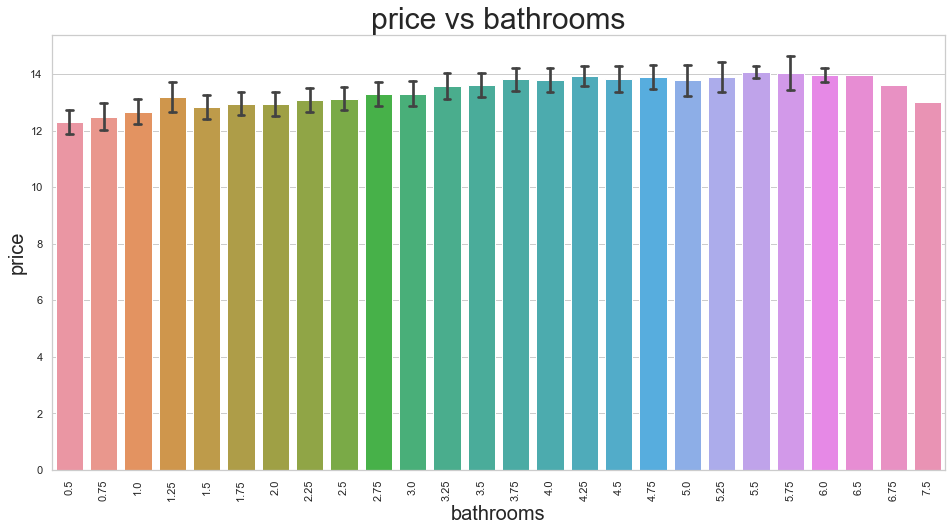

In [26]:
# let's take a look at bathrooms first
sns.set(style="whitegrid")
#housing = sns.load_dataset("tips")
col='bathrooms'

plt.figure(figsize=(16,8))
plt.title('price vs '+col, fontsize=30)
ax = sns.barplot(x=col, y="price", data=kc, ci="sd", capsize=0.2)
ax.set_xlabel(col, fontsize=20)
ax.set_ylabel("price", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('img/'+col+'.png') # Save that figure
plt.show()


In [27]:
kc['tot_bathrooms'] = kc.apply(lambda row: row.bathrooms * row.bedrooms, axis=1)
display(kc[['bedrooms', 'bathrooms', 'tot_bathrooms']].head())
print(kc.columns)

,bedrooms,bathrooms,tot_bathrooms
0,3,1.00,3.00
1,3,2.25,6.75
2,2,1.00,2.00
3,4,3.00,12.00
4,3,2.00,6.00


Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'tot_bathrooms', 'r'],
      dtype='object')


In [28]:
# now let's redo the OLS by replacing bathrooms with 'tot_bathrooms'
tmp_kc = kc.drop(["id", "date", 'bathrooms'], axis=1) # obviously date datatype won't work with OLS  
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     3752.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:35   Log-Likelihood:                -764.32
No. Observations:               21398   AIC:                             1565.
Df Residuals:                   21380   BIC:                             1708.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.232e+04   1939.458     -6.351

the change bathrooms --> tot_bathrooms, reduced R2 from 0.750 --> 0.748. This is not bad. Let's visualize vai barchart

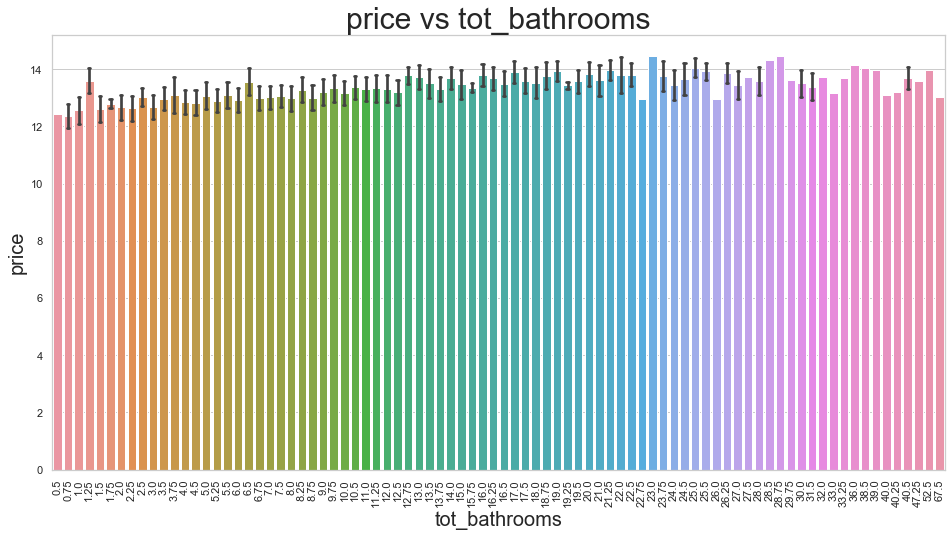

In [29]:
sns.set(style="whitegrid")
#housing = sns.load_dataset("tips")
col='tot_bathrooms'

plt.figure(figsize=(16,8))
plt.title('price vs '+col, fontsize=30)
ax = sns.barplot(x=col, y="price", data=kc, ci="sd", capsize=0.2)
ax.set_xlabel(col, fontsize=20)
ax.set_ylabel("price", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('img/'+col+'.png') # Save that figure
plt.show()


In [30]:
# Let's drop bathrooms and see what happens 
#kc = kc.drop(['bathrooms'], axis=1) 
# after rerunning everything twice it appears tot_bathrooms do not add much to the overall accuracy of the model. 
#Let's drop it 
kc = kc.drop(['tot_bathrooms'], axis=1) 

### Categorize 'Date' variable to show season   
The feature 'date' is the date the souse sold in king county. A date data type will not be included in the regression. Thus, it may be better to categorize the date into season. 

C:\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


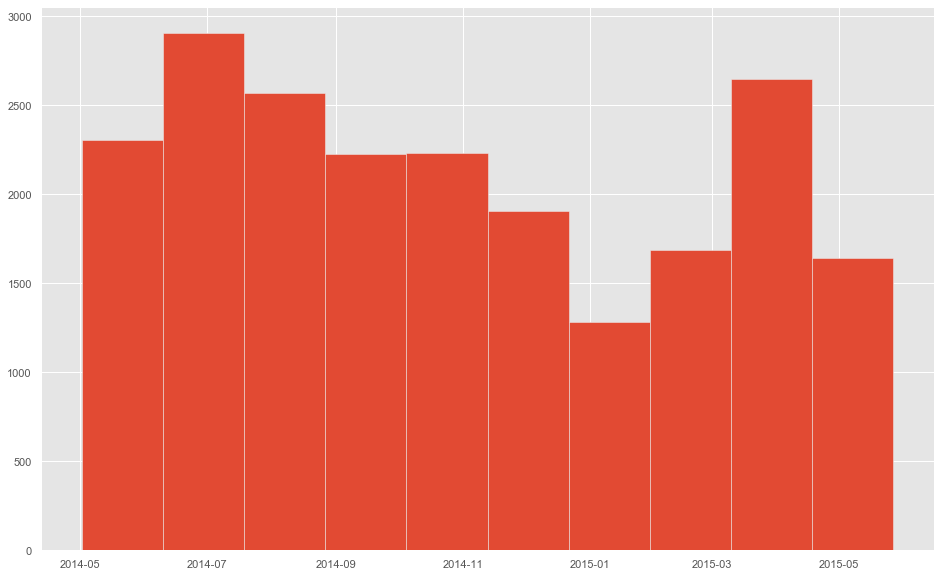

In [31]:
plt.style.use('ggplot')
kc.date.hist()

In [32]:
kc['month'] = kc['date'].dt.month # add a month column to the dataframe
kc.month.unique()

array([10, 12,  2,  5,  6,  1,  4,  3,  7,  8, 11,  9], dtype=int64)

0          fall
1        winter
2        winter
3        winter
4        winter
          ...  
21393    spring
21394    winter
21395    spring
21396    winter
21397      fall
Name: season, Length: 21398, dtype: category
Categories (4, object): [winter, spring, summer, fall]

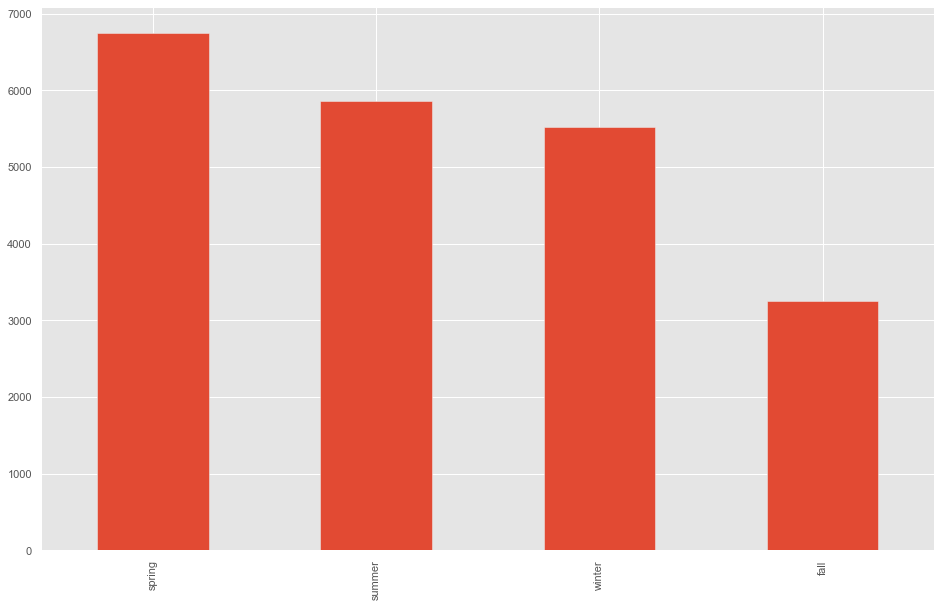

In [33]:
kc.month = kc.month.replace(12, 0) # change 12 to 0 so that 0-2 represent winter
#creating bins for the season
bins = [0, 3, 6, 9, 11]
kc['season'] = pd.cut(kc['month'], bins, include_lowest = True, labels = ["winter", "spring", "summer", "fall"])
kc['season'] = kc['season'].cat.as_unordered()
kc['season'].value_counts().plot(kind='bar')
kc.season

### prepare other categorical features to sting   

In [34]:
#print(kc.columns[0:20])
check_cat = ['waterfront', 'condition', 'floors', 'view', 'grade', 'sqft_basement']
                      
for feature in check_cat:
    print("unique values of \'{}\' predictor".format(feature))
    display(kc[feature].value_counts())

unique values of 'waterfront' predictor


0.0    21295
1.0      103
Name: waterfront, dtype: int64

unique values of 'condition' predictor


3    13899
4     5631
5     1670
2      169
1       29
Name: condition, dtype: int64

unique values of 'floors' predictor


1.0    10638
2.0     8106
1.5     1898
3.0      607
2.5      143
3.5        6
Name: floors, dtype: int64

unique values of 'view' predictor


0.0    19414
2.0      930
3.0      483
1.0      317
4.0      254
Name: view, dtype: int64

unique values of 'grade' predictor


7     8972
8     6060
9     2597
6     2038
10    1075
11     329
5      242
12      56
4       27
13       1
3        1
Name: grade, dtype: int64

unique values of 'sqft_basement' predictor


0.0       13225
600.0       215
500.0       209
700.0       205
800.0       200
          ...  
602.0         1
1281.0        1
915.0         1
2130.0        1
1890.0        1
Name: sqft_basement, Length: 291, dtype: int64

The numerical variable looks catergorical. However, except wavefront rest can be assumed as a numerical data for the puspose of regression. 
let's encode wavefront onto string. 

In [35]:
kc['waterfront'] = kc['waterfront'].astype("str")

In [36]:
# let's remove unnecessary and binned 
kc = kc.drop(['date', 'month'], axis =1 )

### One-Hot Encoding to handle the categorical features 

In [37]:
kc = pd.get_dummies(kc) #one-hot encoding our data
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21398 entries, 0 to 21397
Data columns (total 24 columns):
id                21398 non-null int64
price             21398 non-null float64
bedrooms          21398 non-null int64
bathrooms         21398 non-null float64
sqft_living       21398 non-null float64
sqft_lot          21398 non-null float64
floors            21398 non-null float64
view              21398 non-null float64
condition         21398 non-null int64
grade             21398 non-null int64
sqft_basement     21398 non-null float64
yr_built          21398 non-null int64
zipcode           21398 non-null int64
lat               21398 non-null float64
long              21398 non-null float64
sqft_living15     21398 non-null float64
sqft_lot15        21398 non-null float64
r                 21398 non-null float64
waterfront_0.0    21398 non-null uint8
waterfront_1.0    21398 non-null uint8
season_winter     21398 non-null uint8
season_spring     21398 non-null uint8
season_su

In [38]:
kc.rename(columns={'waterfront_0.0' : 'waterfront_0', 'waterfront_1.0' : 'waterfront_1'}, inplace=True)

In [39]:
kc.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r',
       'waterfront_0', 'waterfront_1', 'season_winter', 'season_spring',
       'season_summer', 'season_fall'],
      dtype='object')

## Min-Max Normalization
Min-max normalization make most sense for this data. 


In [40]:
#let's seperate categorical features before normalization 
#kc_cat=kc[['id', 'price', 'bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'yr_built', 'zipcode',
#           'waterfront_0', 'waterfront_1', 'season_winter', 'season_spring', 'season_summer', 'season_fall' ]]
#kc_num=kc[['sqft_living', 'sqft_lot', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', ]]

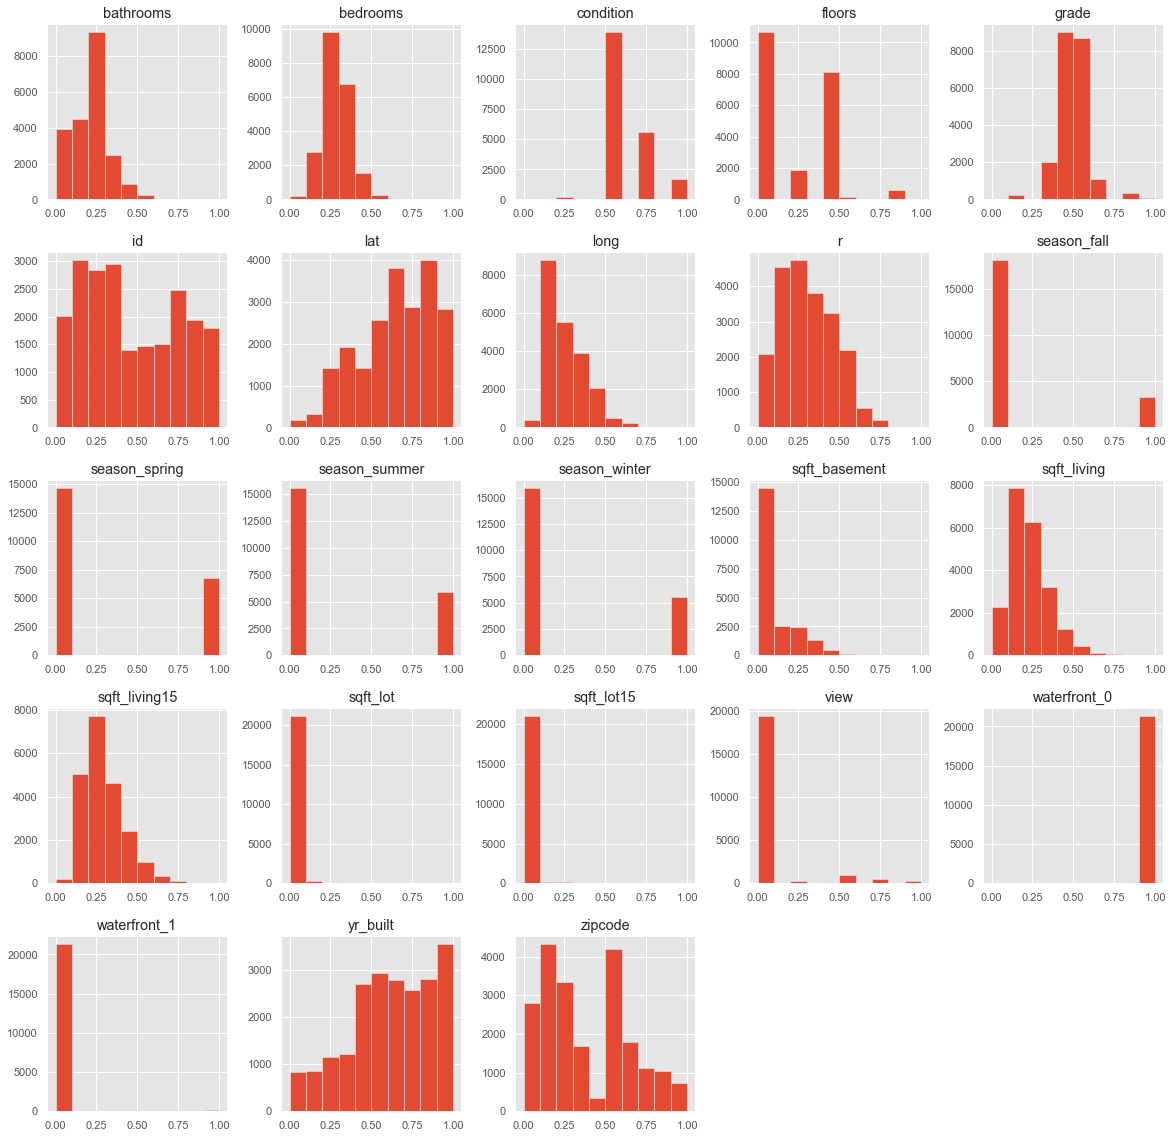

In [41]:
# min-max scaler (normalization using y= (x-min)/(max-min))
from sklearn.preprocessing import MinMaxScaler 

#let's drop the price for it's not included in the normalize
kc_norm = kc.drop(['price'], axis =1 )

scaler = MinMaxScaler() # instantiate 
kc_norm = pd.DataFrame(scaler.fit_transform(kc_norm), columns = kc_norm.columns)
kc_norm.hist(figsize = (20,20));

In [42]:
#display(kc_norm.columns)
# add the price column to the mean normalized dataset. 
kc_norm['price']=kc['price']
#kc_norm=pd.concat([kc_cat, kc_norm], axis=1)
#display(kc_norm.columns)


In [43]:
kc_norm.columns

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r', 'waterfront_0',
       'waterfront_1', 'season_winter', 'season_spring', 'season_summer',
       'season_fall', 'price'],
      dtype='object')

### Let's redo OLS after normalization

In [44]:
# one col from each category can be dropped because one would be linearly dependnt. 
kc_final = kc_norm.drop(['waterfront_0', 'season_winter'], axis =1 )
# kc_final = kc_final.drop(['lat','long'], axis =1 )

In [45]:
display(kc_final.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_basement', 'yr_built', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'r', 'waterfront_1',
       'season_spring', 'season_summer', 'season_fall', 'price'],
      dtype='object')

formula = price ~ bedrooms


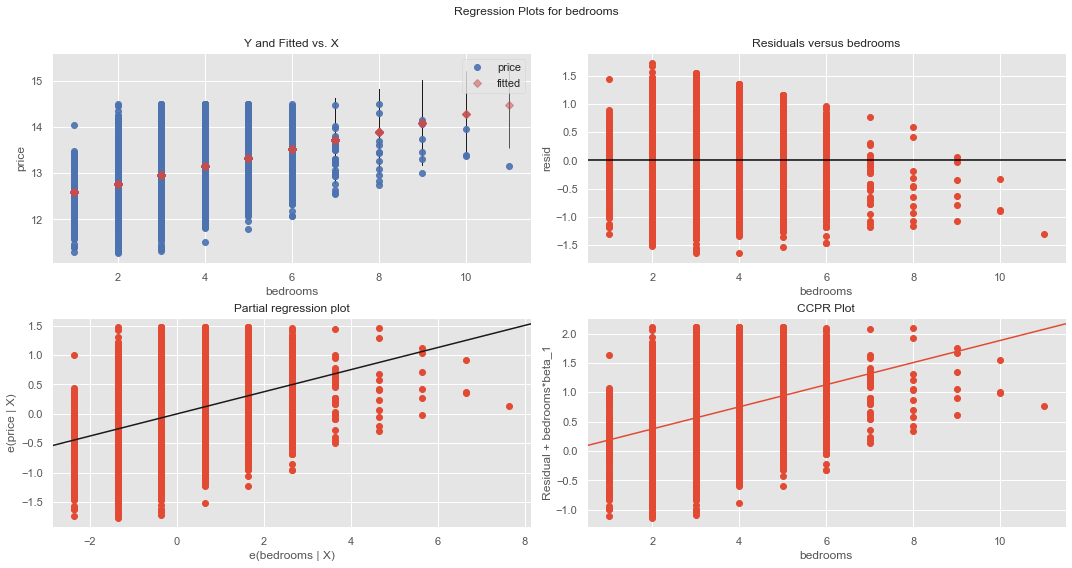

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2758.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:44   Log-Likelihood:                -14255.
No. Observations:               21398   AIC:                         2.851e+04
Df Residuals:                   21396   BIC:                         2.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3988      0.012    993.613      0.0

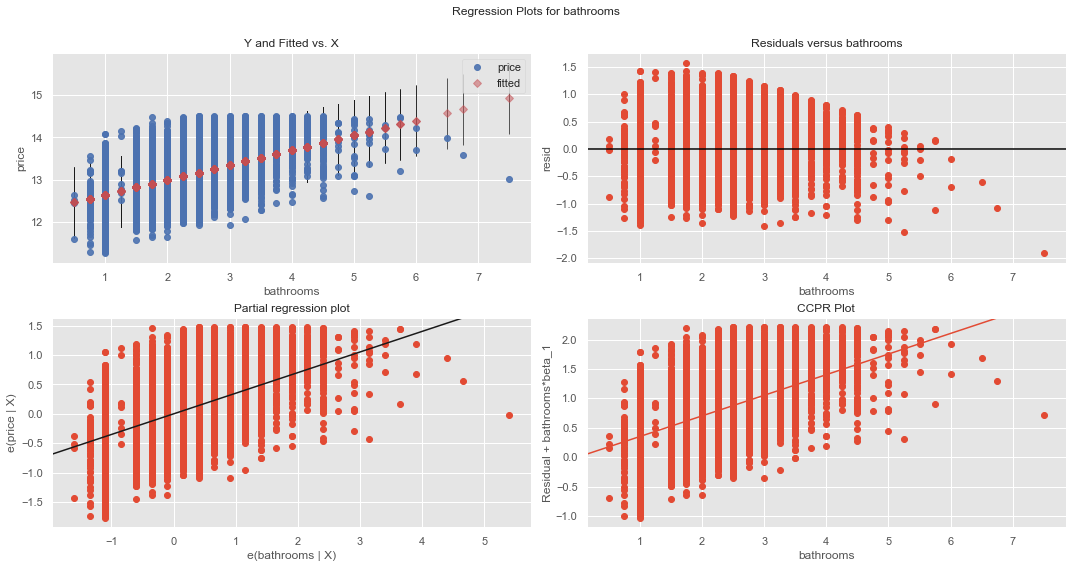

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     8070.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:46   Log-Likelihood:                -12128.
No. Observations:               21398   AIC:                         2.426e+04
Df Residuals:                   21396   BIC:                         2.428e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.2953      0.009   1412.650      0.0

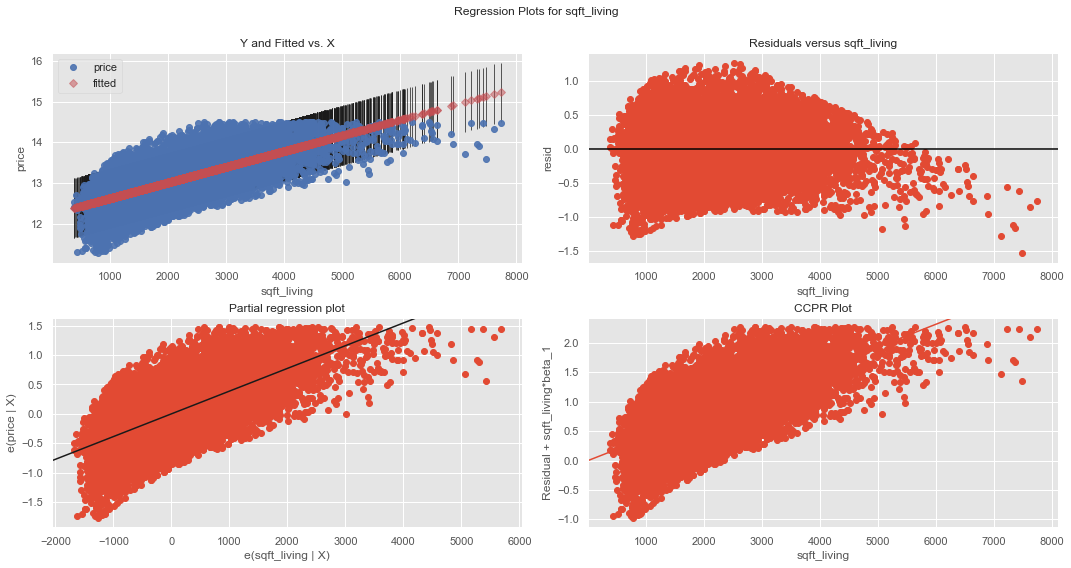

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                 1.716e+04
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:48   Log-Likelihood:                -9250.9
No. Observations:               21398   AIC:                         1.851e+04
Df Residuals:                   21396   BIC:                         1.852e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2381      0.007   1861.588      

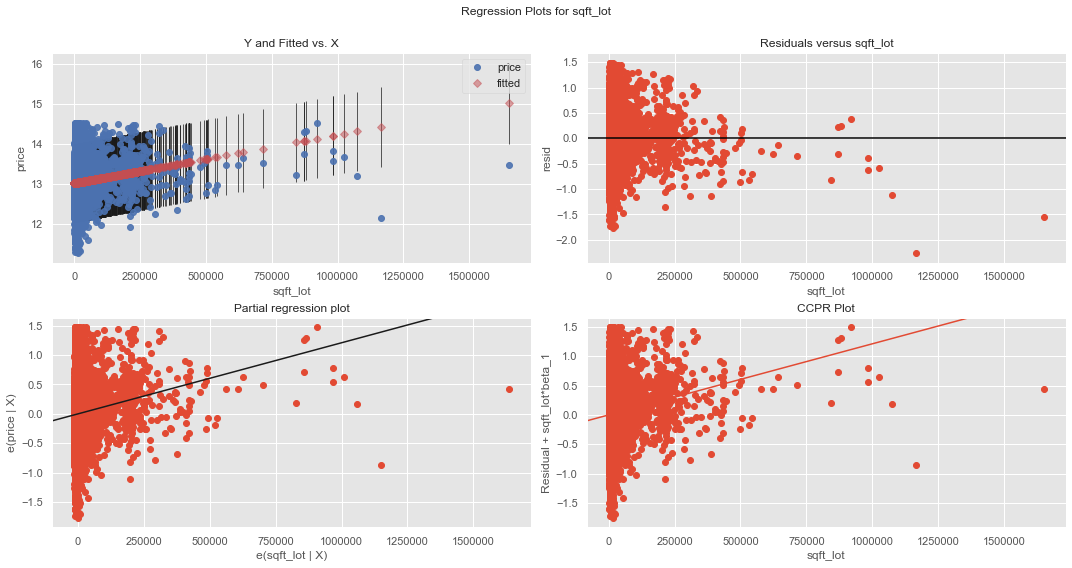

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     216.5
Date:                Wed, 06 May 2020   Prob (F-statistic):           8.95e-49
Time:                        11:59:50   Log-Likelihood:                -15445.
No. Observations:               21398   AIC:                         3.089e+04
Df Residuals:                   21396   BIC:                         3.091e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0138      0.004   3593.240      0.0

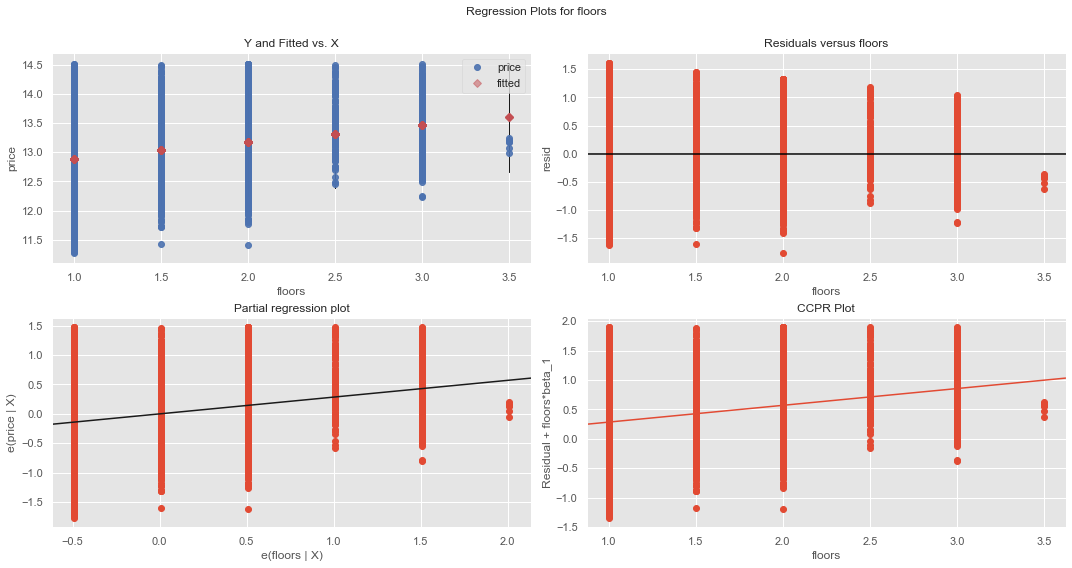

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2228.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:51   Log-Likelihood:                -14492.
No. Observations:               21398   AIC:                         2.899e+04
Df Residuals:                   21396   BIC:                         2.900e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6069      0.010   1316.490      0.0

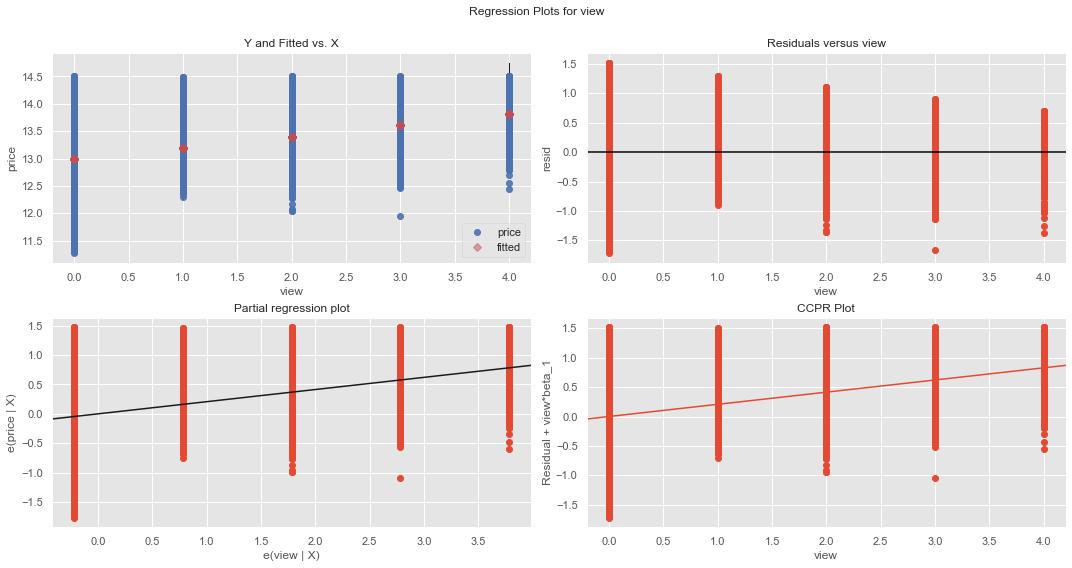

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     2157.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:54   Log-Likelihood:                -14525.
No. Observations:               21398   AIC:                         2.905e+04
Df Residuals:                   21396   BIC:                         2.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9870      0.003   3817.711      0.0

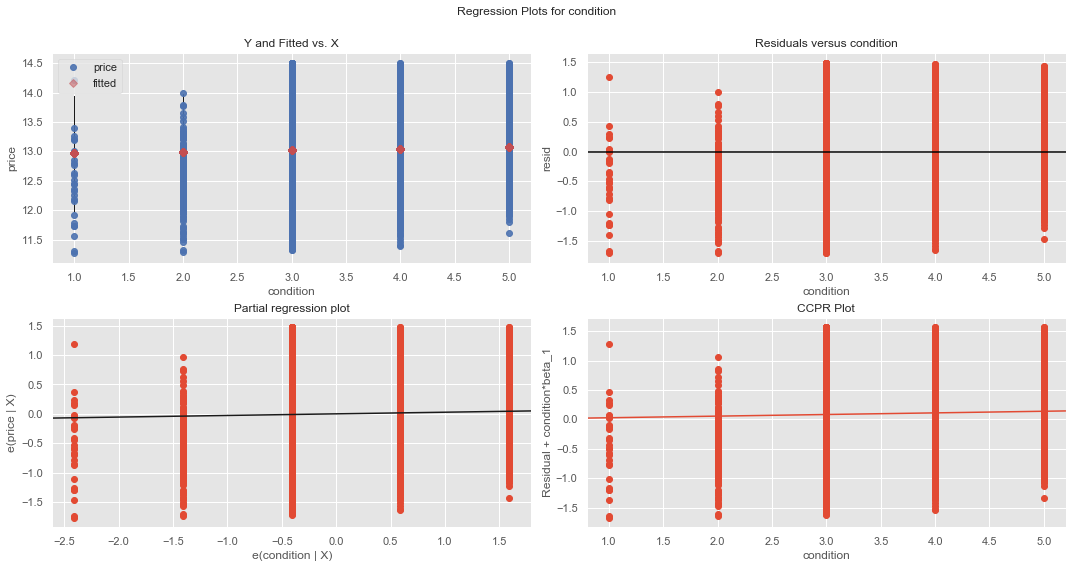

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.50
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.59e-07
Time:                        11:59:56   Log-Likelihood:                -15539.
No. Observations:               21398   AIC:                         3.108e+04
Df Residuals:                   21396   BIC:                         3.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9378      0.018    708.041      0.0

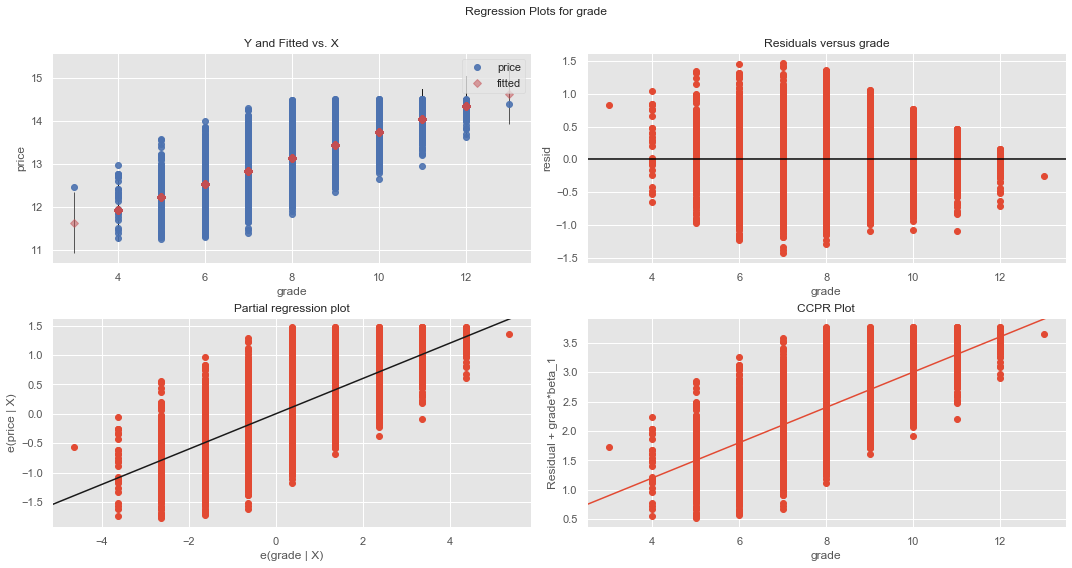

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                 1.858e+04
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:57   Log-Likelihood:                -8865.3
No. Observations:               21398   AIC:                         1.773e+04
Df Residuals:                   21396   BIC:                         1.775e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.7399      0.017    631.688      0.0

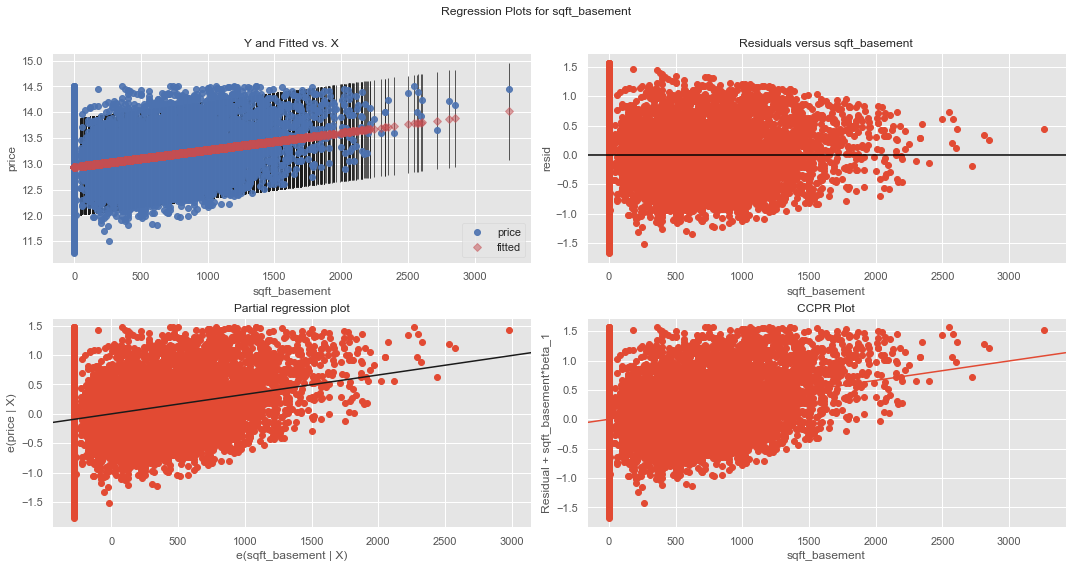

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1865.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        11:59:59   Log-Likelihood:                -14658.
No. Observations:               21398   AIC:                         2.932e+04
Df Residuals:                   21396   BIC:                         2.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.9396      0.004   3303.617

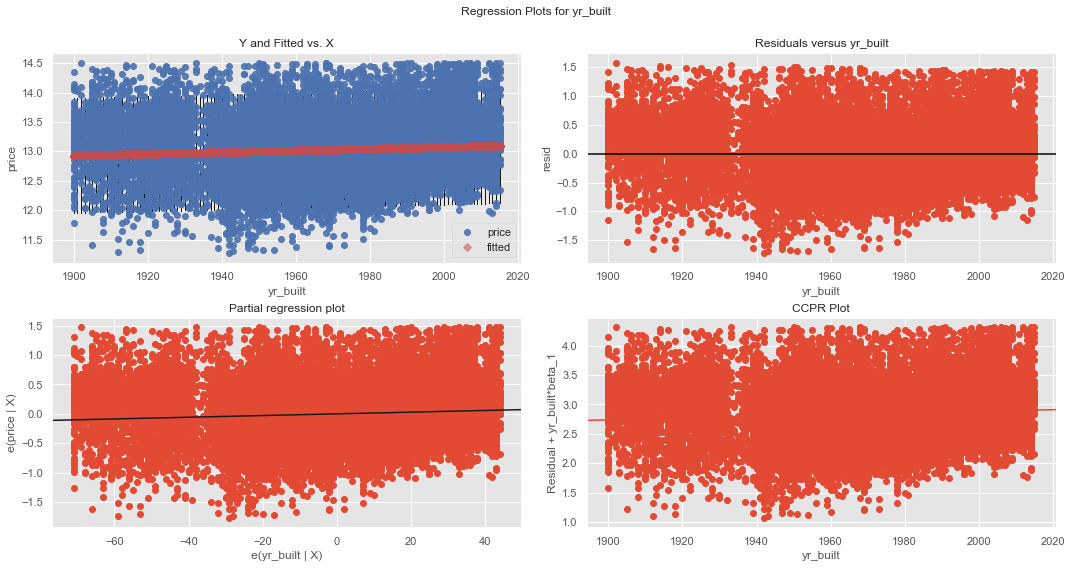

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     153.5
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.96e-35
Time:                        12:00:01   Log-Likelihood:                -15476.
No. Observations:               21398   AIC:                         3.096e+04
Df Residuals:                   21396   BIC:                         3.097e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.1917      0.229     44.451      0.0

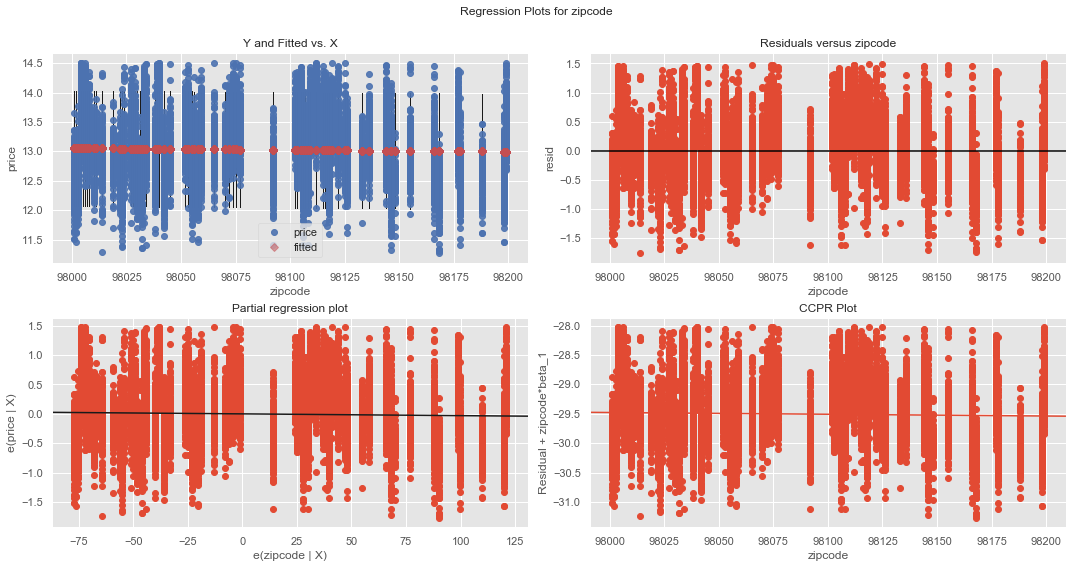

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.13
Date:                Wed, 06 May 2020   Prob (F-statistic):           2.57e-06
Time:                        12:00:03   Log-Likelihood:                -15541.
No. Observations:               21398   AIC:                         3.109e+04
Df Residuals:                   21396   BIC:                         3.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.5334      6.272      6.782      0.0

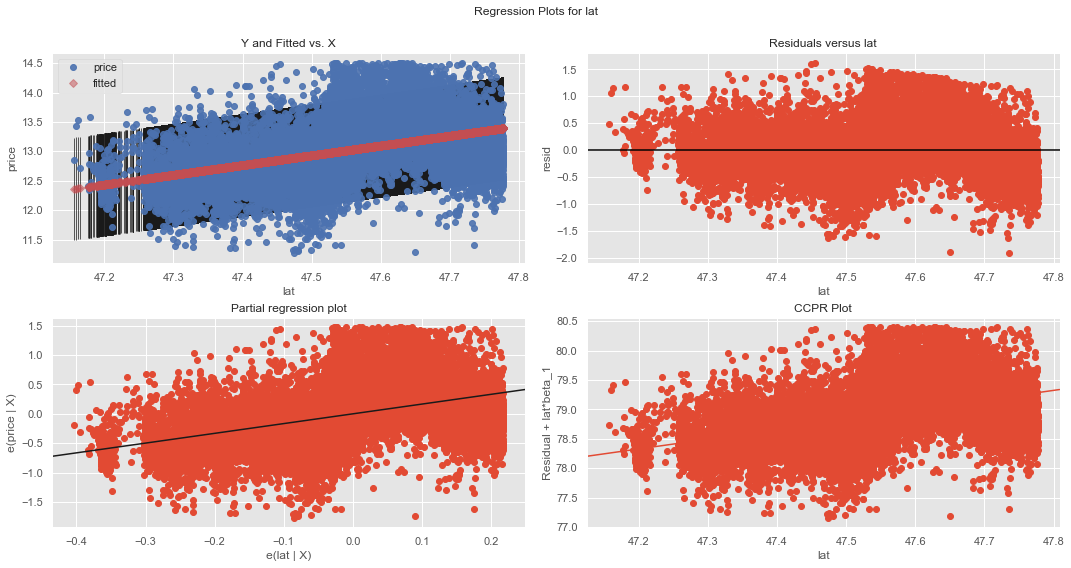

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     5769.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:05   Log-Likelihood:                -12998.
No. Observations:               21398   AIC:                         2.600e+04
Df Residuals:                   21396   BIC:                         2.602e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -65.8941      1.039    -63.412      0.0

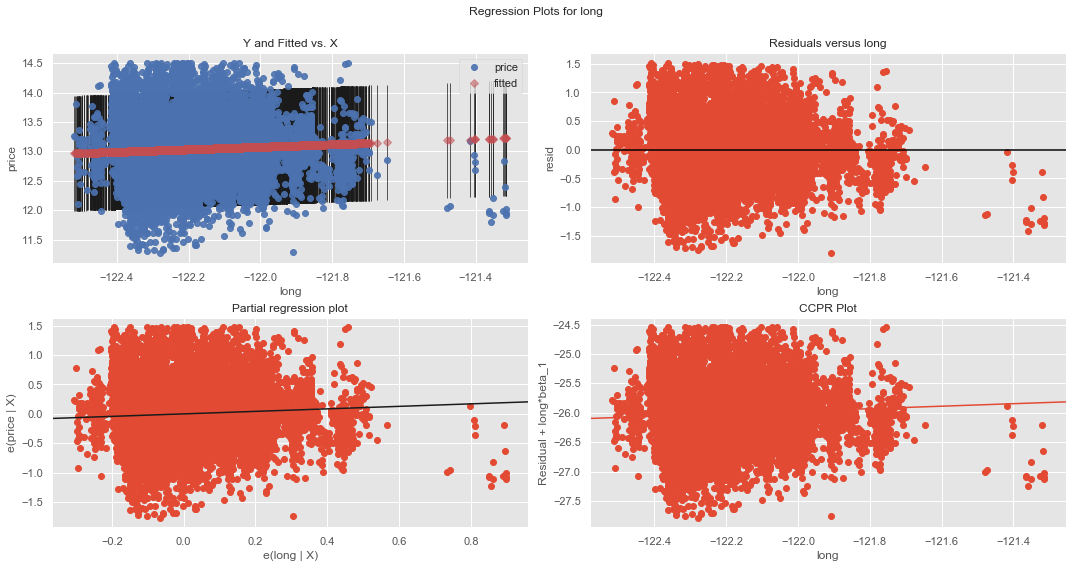

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     77.37
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.52e-18
Time:                        12:00:07   Log-Likelihood:                -15514.
No. Observations:               21398   AIC:                         3.103e+04
Df Residuals:                   21396   BIC:                         3.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.0513      2.958     13.202      0.0

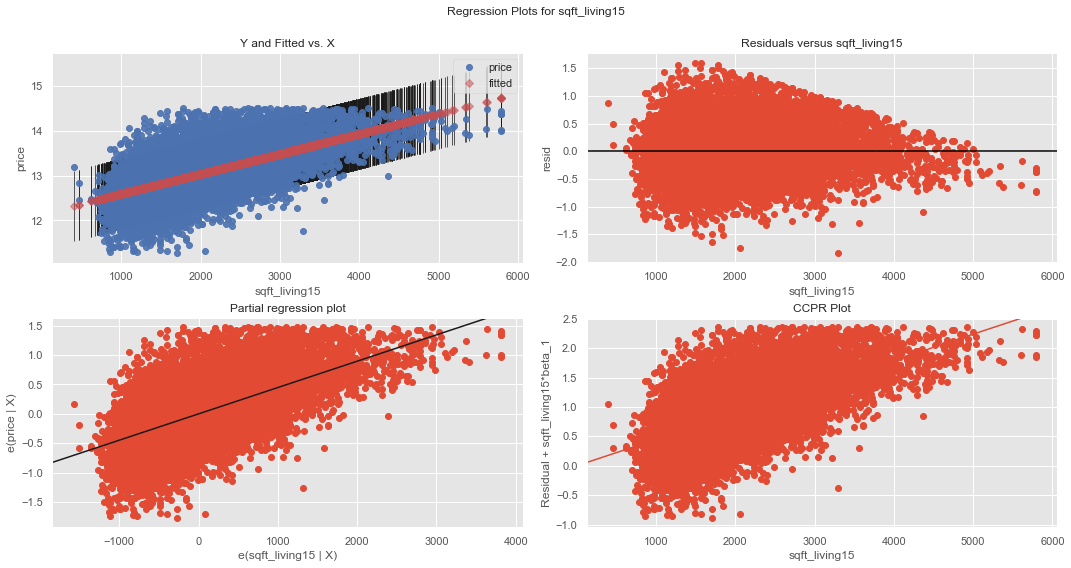

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                 1.194e+04
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:09   Log-Likelihood:                -10808.
No. Observations:               21398   AIC:                         2.162e+04
Df Residuals:                   21396   BIC:                         2.163e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.1484      0.009   1422.914

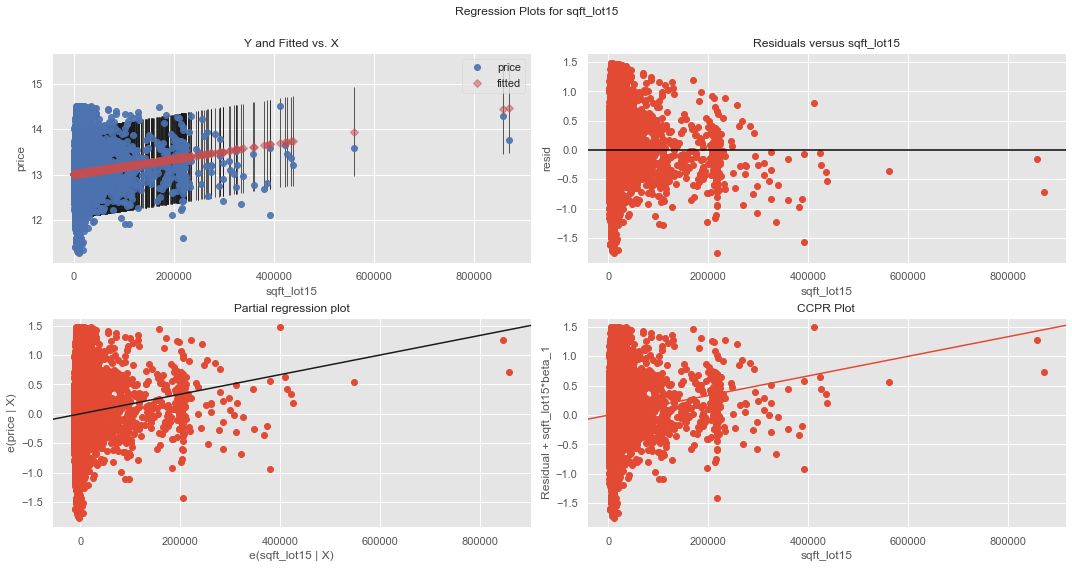

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.38e-40
Time:                        12:00:10   Log-Likelihood:                -15463.
No. Observations:               21398   AIC:                         3.093e+04
Df Residuals:                   21396   BIC:                         3.095e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0108      0.004   3461.640      0.0

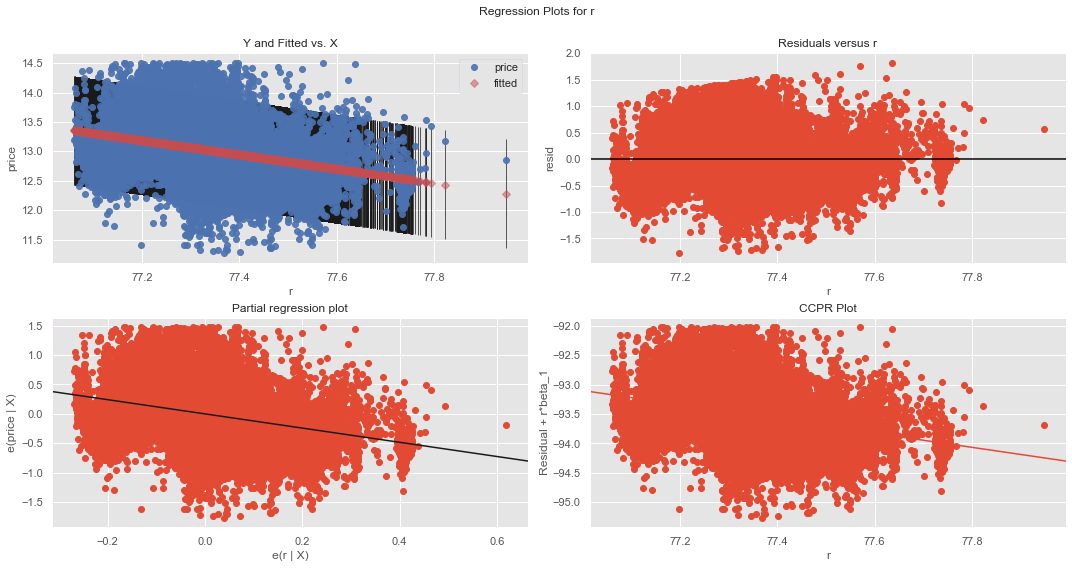

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2941.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:12   Log-Likelihood:                -14175.
No. Observations:               21398   AIC:                         2.835e+04
Df Residuals:                   21396   BIC:                         2.837e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    106.5279      1.724     61.785      0.0

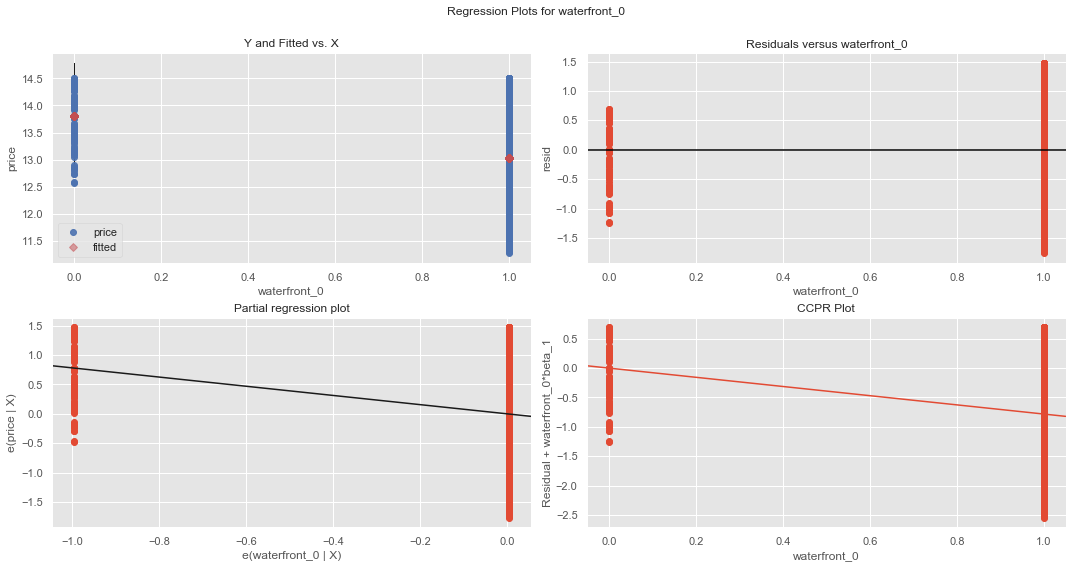

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     253.3
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.04e-56
Time:                        12:00:14   Log-Likelihood:                -15426.
No. Observations:               21398   AIC:                         3.086e+04
Df Residuals:                   21396   BIC:                         3.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.8104      0.049    281.675   

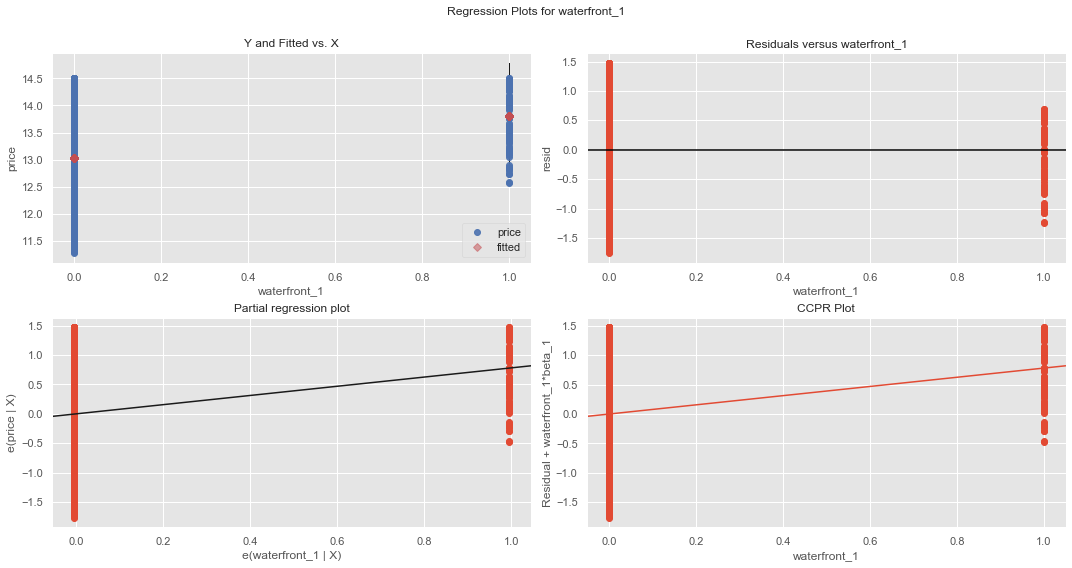

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     253.3
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.04e-56
Time:                        12:00:16   Log-Likelihood:                -15426.
No. Observations:               21398   AIC:                         3.086e+04
Df Residuals:                   21396   BIC:                         3.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.0282      0.003   3820.727   

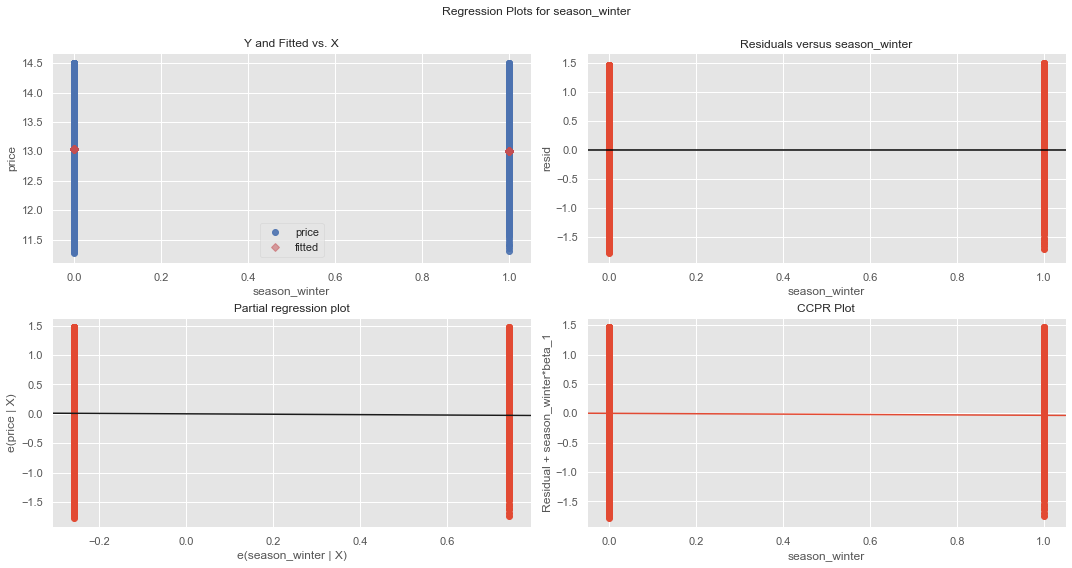

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     18.83
Date:                Wed, 06 May 2020   Prob (F-statistic):           1.44e-05
Time:                        12:00:17   Log-Likelihood:                -15543.
No. Observations:               21398   AIC:                         3.109e+04
Df Residuals:                   21396   BIC:                         3.111e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0407      0.004   3284.410

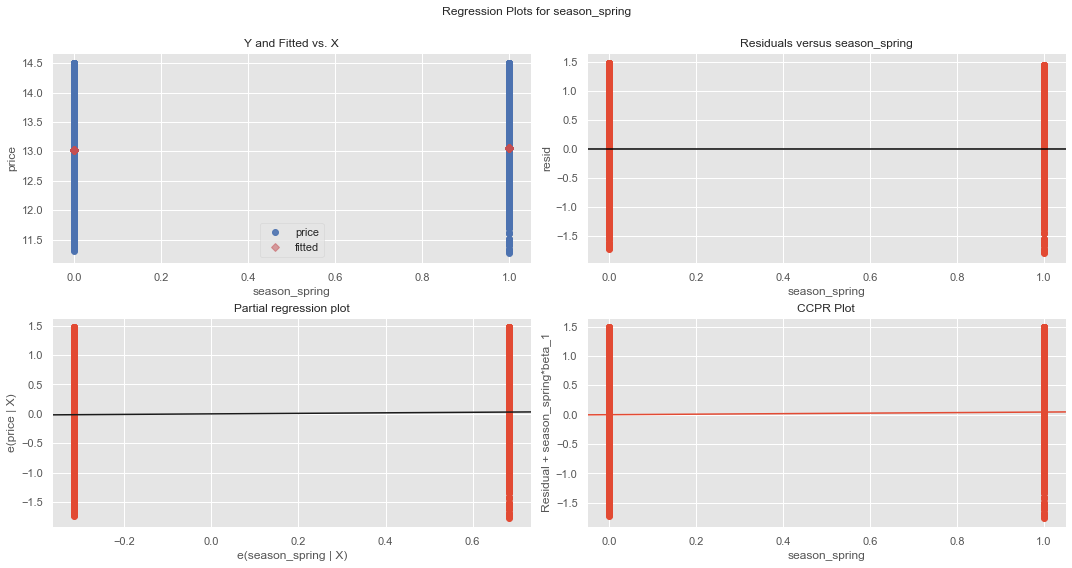

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     37.53
Date:                Wed, 06 May 2020   Prob (F-statistic):           9.15e-10
Time:                        12:00:19   Log-Likelihood:                -15534.
No. Observations:               21398   AIC:                         3.107e+04
Df Residuals:                   21396   BIC:                         3.109e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0177      0.004   3150.126

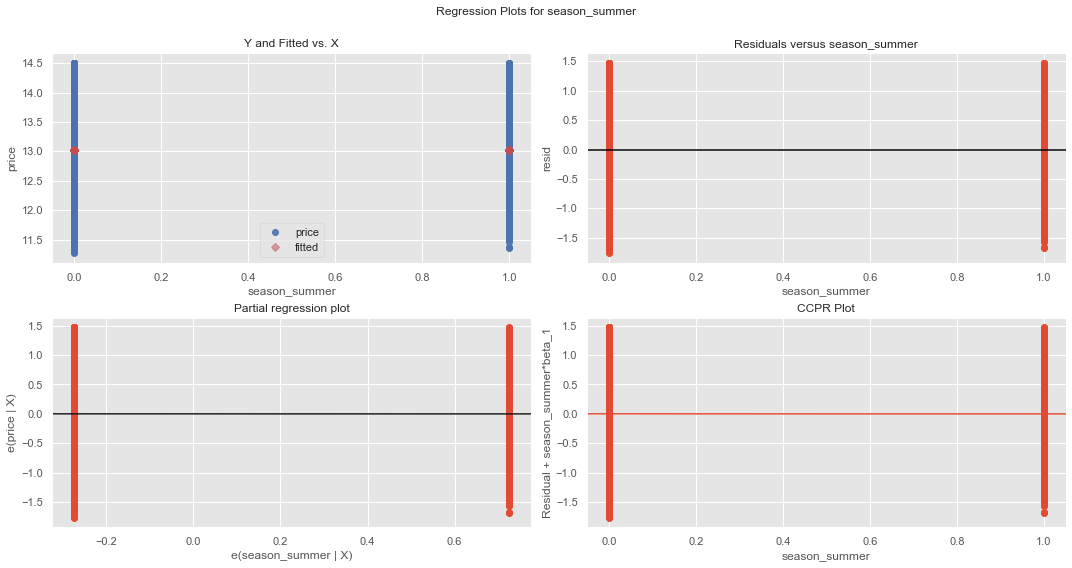

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01871
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.891
Time:                        12:00:21   Log-Likelihood:                -15552.
No. Observations:               21398   AIC:                         3.111e+04
Df Residuals:                   21396   BIC:                         3.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        13.0322      0.004   3244.788

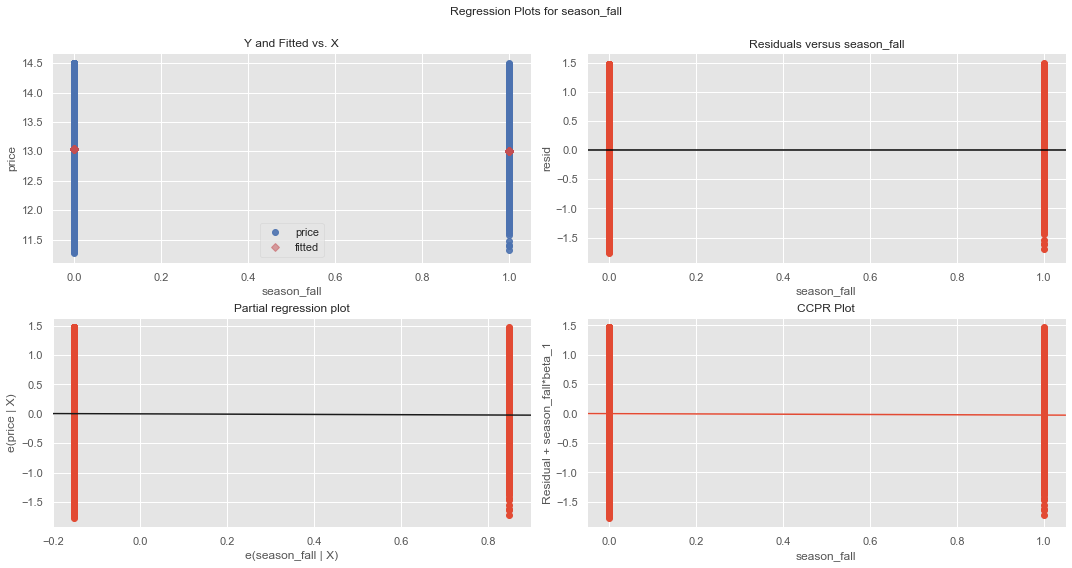

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.083
Date:                Wed, 06 May 2020   Prob (F-statistic):             0.0137
Time:                        12:00:23   Log-Likelihood:                -15549.
No. Observations:               21398   AIC:                         3.110e+04
Df Residuals:                   21396   BIC:                         3.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      13.0355      0.004   3508.136      

In [46]:
tmp_kc = kc.drop(["id"], axis=1) # remove id
predictors = list(tmp_kc.columns)
predictors.remove('price')

for i in range(len(predictors)):
    print("formula = price ~ "+predictors[i])
    f = 'price ~ ' + predictors[i]
    model = ols(formula=f, data=tmp_kc).fit()
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, predictors[i], fig=fig)
    plt.show()
    print(model.summary())
    print("################################################################################\n\n")

In [47]:
# What's the total R2 after normalization ?  drop 'lay' and 'long' first
tmp_kc = kc.drop(["id", 'lat', 'long'], axis=1) # remove id
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     3285.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:23   Log-Likelihood:                -1364.9
No. Observations:               21398   AIC:                             2768.
Df Residuals:                   21379   BIC:                             2919.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       133.4134      2.615     51.009

In [48]:
# What's the total R2 after normalization ?  drop 'r' 
tmp_kc = kc.drop(["id", 'r'], axis=1) # remove id
predictors = list(tmp_kc.columns)
predictors.remove('price')

f = 'price ~ ' + ' + '.join(predictors)       
model = ols(formula=f, data=tmp_kc).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     3396.
Date:                Wed, 06 May 2020   Prob (F-statistic):               0.00
Time:                        12:00:24   Log-Likelihood:                -671.72
No. Observations:               21398   AIC:                             1383.
Df Residuals:                   21378   BIC:                             1543.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.8078      2.085     -0.867

The distance feature 'r' is reduec the R2 just a little compared to 'lat' and 'long'. Let's still keep it for now and choose in feature engineering. 

## All data is normalized and ready for validation
Save the clean data to a kc_house_data_clean.csv file

In [49]:
kc_final.to_csv('data/kc_house_data_normalized.csv', index=False)

<p style="font-size:200%; text-align:center">Please open validation.ipynb next for final model</p>